In [1]:
import numpy as np
import pynbody
from pynbody.plot import sph
import matplotlib.pylab as plt
plt.style.use('dark_background')

In [2]:
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
from snap_io import load_moria_sim_and_kicked, load_moria, load_kicked, load_sim

In [3]:
import contextlib
@contextlib.contextmanager
def np_printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [4]:
SIMNUMBER = "69002_p200.0_a600.0_r600.0_c8.15"
kicked=True
snap_list = load_kicked(SIMNUMBER) if kicked else load_moria(SIMNUMBER)
s = snap_list[0]
s

<SimSnap "/home/michele/sim/MySimulations/Moria8Gyr_tidal/sim69002_p200.0_a600.0_r600.0_c8.15/out/snapshot_0001" len=1871020>

In [5]:
resolution = 500
width = 10 # kpc
vmax=2e-1
vmin=5e-4;

In [6]:
def get_sim_global_info(snap_list):
    time_range = snap_list[0].properties['time'].in_units("Gyr"), snap_list[-1].properties['time'].in_units("Gyr")
    

def plot_gas_and_stars_sfh(sim, velocity_proj=False, sfh=False, **kwargs):
    """Wrapper around pynbody.plot.stars.render using correct smoothing length"""
    sim.properties.pop('boxsize', None)
    sim.g['smooth'] /= 2
    sim.s['smooth'] /= 2
    pynbody.analysis.halo.center(sim)
    sim_time_gyr = sim.properties['time'].in_units("Gyr")

    if velocity_proj:
        """x-axis is aligned with the overall mean velocity of
        the snaphot and the vertical axis is the z axis rotated by the elevation angle
        of the velocity"""
        velocity = sim['vel'].mean(axis=0)
        backup = sim['pos'].copy()
        backup_v = sim['vel'].copy()
        v_xy = np.linalg.norm(velocity[0:2])
        v_x, v_y, v_z = velocity
        alpha = np.sign(v_y) * np.arccos(v_x/v_xy) * 180.0/np.pi
        theta = np.arctan(v_z/v_xy) * 180.0/np.pi
        r1=sim.rotate_z(alpha)
        r2=sim.rotate_y(theta)

    fig, (ax_g, ax_s) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    width=kwargs.get("width", 20)
    kwargs.pop("width", None)

    try:
        snap = int(sim.filename[-4:])
#         with np_printoptions(precision=2):
#             title = '$t={:5.2f}$ Gyr, snap={}\nv = {}'.format(sim.properties['time'].in_units("Gyr"), snap, velocity)
        im = sph.image(sim.g, qty="rho", units="g cm^-2", subplot=ax_g, #title=title,
                       ret_im=True, show_cbar=False, width=width, **kwargs)
        rgbim = pynbody.plot.stars.render(sim, axes=ax_s, width=width, clear=False, plot=False, ret_im=True)
        ax_s.imshow(rgbim[::-1, :], extent=(-width / 2, width / 2, -width / 2, width / 2))
        ax_s.set_xlabel('x [' + str(sim.s['x'].units) + ']')
        ax_s.set_ylabel('y [' + str(sim.s['y'].units) + ']')
        ax_g.set_xlabel('x [' + str(sim.s['x'].units) + ']')
        ax_g.set_ylabel('y [' + str(sim.s['y'].units) + ']')
        
        fig.tight_layout() # only plots above are affected
        fig.subplots_adjust(top=0.92, bottom=0.15)
        cbar_ax = fig.add_axes([0.2,  0.06, 0.6, 0.02])
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal').set_label("rho [g cm^-2]")
        if sfh:
            #  [left, bottom, width, height]
            ax_sfh = fig.add_axes([0.1,  -0.3, 0.35, 0.26])
            # ignore AccuracyWarning that is issued when an integral is zero
            import warnings
            from scipy.integrate.quadrature import AccuracyWarning
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=AccuracyWarning)
                my_range = (0, 13.7)
                pynbody.plot.stars.sfh(sim, trange=my_range, range=my_range, subplot=ax_sfh)
            ax_sfh.axvline(x=sim_time_gyr, linestyle="--")
            ax_sfh.set_xlabel("Time [Gyr]")
            ax_sfh.set_ylabel("SFR [M$_\odot$ yr$^{-1}$]")
        title = '$t={:5.2f}$ Gyr, snap={}'.format(sim_time_gyr, snap)
        if velocity_proj:
            with np_printoptions(precision=2):
                title+="\nv = {} km/s".format(velocity)
        fig.suptitle(title)
    except Exception as e:
        raise(e)
    finally:
        sim.g['smooth'] *= 2
        sim.s['smooth'] *= 2
        if velocity_proj:
            # revert is costly (7% for each transformation w.r.t. the sph.image function)
            # and does not work when the transformation has been applied on a particle family
            # r2.revert()
            # r1.revert()
            sim['pos'] = backup
            sim['vel'] = backup_v
    return

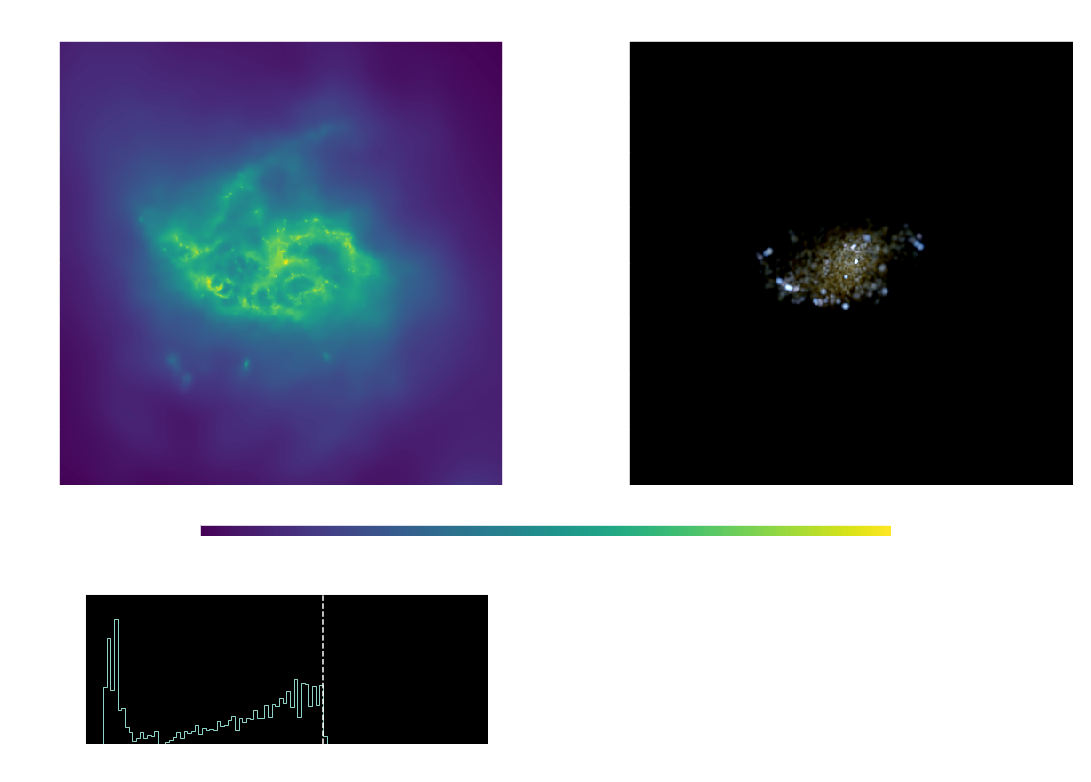

In [7]:
plot_gas_and_stars_sfh(s, sfh=True)

In [8]:
vminmax = ipywidgets.FloatRangeSlider(
    value=[vmin, vmax],
    min=1e-6,
    max=1e-2,
    step=1e-5,
    description='Rho:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='1.0e',
)
snap_slider = ipywidgets.IntSlider(min=0,max=len(snap_list)-1,step=1,value=0, continuous_update=False, description='Snap:')
width_slider = ipywidgets.IntSlider(min=5,max=1000,step=10,value=20, continuous_update=False, description='Width (kpc):')
res_slider = ipywidgets.IntSlider(min=100,max=1000,step=100,value=200, continuous_update=False, description='Resol. (pix):')
proj = ipywidgets.Checkbox(value=False,  description='Velocity projection')
sfh = ipywidgets.Checkbox(value=True,  description='SFH')

def k(i, velocity_proj, sfh, vrange, width, resolution):
    plot_gas_and_stars_sfh(snap_list[i], velocity_proj=velocity_proj, sfh=sfh, width=width, vmin=vrange[0], vmax=vrange[1], resolution=resolution)

In [9]:
interact(k, i=snap_slider, velocity_proj=proj, sfh=sfh, vrange=vminmax, width=width_slider, resolution=res_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=94), Checkbox(value=False, description='Velocity projection'), Checkbox(value=True, description='SFH'), FloatRangeSlider(value=(0.0005, 0.01), continuous_update=False, description='Rho:', max=0.01, min=1e-06, readout_format='1.0e', step=1e-05), IntSlider(value=20, continuous_update=False, description='Width (kpc):', max=1000, min=5, step=10), IntSlider(value=200, continuous_update=False, description='Resol. (pix):', max=1000, min=100, step=100), Output()), _dom_classes=('widget-interact',))